https://www.youtube.com/watch?v=rc_Y6rdBqXM&list=PLuueT5PsexC_sbKOFJUHZL7MUdt7G080H&index=87

# For granula level data

In [40]:
!pip install asyncio

You should consider upgrading via the 'c:\users\prita\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [41]:
import pandas as pd 
import sqlalchemy 
from binance.client import Client
from binance import BinanceSocketManager
import asyncio

In [42]:
FEED_DATA = True

In [43]:
def createframe(msg):
    df = pd.DataFrame([msg])
    df = df.loc[:,['s','E','p']]
    df.columns = ['symbol','Time','Price']
    df.Price = df.Price.astype(float)
    df.Time = pd.to_datetime(df.Time,unit='ms')
    return df

In [44]:
# async def feed_continuous_live_data(coin="BTCUSDT"):
#     global FEED_DATA
#     api_key = "1XrUgREgohaYXQxRomXGjdDgJchlHSziqOUmqxsUw2r7WOusHQYIbf71k6wECC3w"
#     api_secret = "8O5kUT3TvQetvhweojMQDYsq9N90VlyJpcsIPI5TxzTn4umOtWZGiaaVq3p4Hpjd"
#     client = Client(api_key=api_key,api_secret=api_secret)
#     bsm = BinanceSocketManager(client)
#     socket = bsm.trade_socket(coin)
#     engine = sqlalchemy.create_engine(f'sqlite:///databases/{coin}stream.db')
    
#     for _ in range(1000):
#         await socket.__aenter__()
#         msg = await socket.recv()
#         frame = createframe(msg)
#         frame.to_sql(coin,engine,if_exists='append',index=False)
    

In [45]:
# def main():
#     coin = "BTCUSDT"
#     asyncio.run(feed_continuous_live_data(coin))

In [46]:
coin = "BTCUSDT"
api_key = "1XrUgREgohaYXQxRomXGjdDgJchlHSziqOUmqxsUw2r7WOusHQYIbf71k6wECC3w"
api_secret = "8O5kUT3TvQetvhweojMQDYsq9N90VlyJpcsIPI5TxzTn4umOtWZGiaaVq3p4Hpjd"
client = Client(api_key=api_key,api_secret=api_secret)
bsm = BinanceSocketManager(client)
socket = bsm.trade_socket(coin)
engine = sqlalchemy.create_engine(f'sqlite:///databases/{coin}stream.db')

for _ in range(50):
    await socket.__aenter__()
    msg = await socket.recv()
    frame = createframe(msg)
    frame.to_sql(coin,engine,if_exists='append',index=False)

# Another script

In [47]:
coin = "BTCUSDT"
df = pd.read_sql(coin,engine)
df.head(10)

,symbol,Time,Price
0,BTCUSDT,2021-10-11 16:15:02.349,57597.02
1,BTCUSDT,2021-10-11 16:15:02.349,57597.02
2,BTCUSDT,2021-10-11 16:15:02.349,57597.02
3,BTCUSDT,2021-10-11 16:15:02.349,57597.02
4,BTCUSDT,2021-10-11 16:15:02.349,57597.02
5,BTCUSDT,2021-10-11 16:15:02.349,57600.00
6,BTCUSDT,2021-10-11 16:15:02.349,57601.98
7,BTCUSDT,2021-10-11 16:15:02.349,57601.98
8,BTCUSDT,2021-10-11 16:15:02.349,57601.98
9,BTCUSDT,2021-10-11 16:15:02.349,57601.98


<AxesSubplot:>

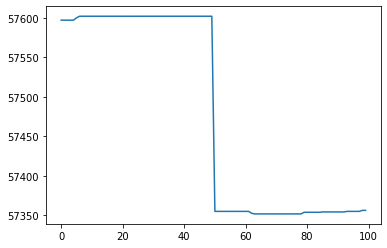

In [48]:
df.Price.plot()

In [49]:
# Trend following
# if the crypto was rising by x% -> buy
# exit when profit is above 0.15% or less is crossing -0.15%

In [50]:
def strategy(entry,lookback,qty,open_position=False,coin = "BTCUSDT"):
    while True:
        df = pd.read_sql(coin,engine)
        lookbackperiod = df[-lookback:]
        cumret = (lookbackperiod.Price.pct_change()+1).cumprod()-1
        if not open_position:
            if cumret[cumret.last_valid_index()] > entry:
                order = client.order(symbol=coin,
                                     side='BUY',
                                     type='MARKET',
                                     quantity=qty)
                print(order)
                open_position = True 
                break
    if open_position:
        while True:
            df = pd.read_sql(coin,engine)
            sincebuy = df.loc[df.Time > pd.to_datetime(order['transactTime'],unit='ms')]
            if len(sincebuy) > 1:
                sincebuyret = (sincebuy.Price.pct_change()+1).cumprod()-1
                last_entry = sincebuyret[sincebuyret.last_valid_index()]
                if last_entry > 0.0015 or last_entry < -0.0015:
                    order = client.order(symbol=coin,
                                     side='SELL',
                                     type='MARKET',
                                     quantity=qty)
                    print(order)
                    break 
                    
                
        

In [51]:
# strategy(0.001,60,0.001) #60 sec